<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Near-Real-Time-Automated-Classification-of-Seismic-Signals-of-Slope-Failures-with-Continuous-Random-Forests" data-toc-modified-id="Near-Real-Time-Automated-Classification-of-Seismic-Signals-of-Slope-Failures-with-Continuous-Random-Forests-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Near Real-Time Automated Classification of Seismic Signals of Slope Failures with Continuous Random Forests</a></span><ul class="toc-item"><li><span><a href="#Some-functions" data-toc-modified-id="Some-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some functions</a></span></li><li><span><a href="#ROC-Analysis" data-toc-modified-id="ROC-Analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>ROC Analysis</a></span></li><li><span><a href="#Model-selection" data-toc-modified-id="Model-selection-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model selection</a></span></li><li><span><a href="#Final-model" data-toc-modified-id="Final-model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Final model</a></span></li></ul></li></ul></div>

# Near Real-Time Automated Classification of Seismic Signals of Slope Failures with Continuous Random Forests
Michaela Wenner, Clement Hibert, Lorenz Meier, Fabian Walter

In [4]:
%matplotlib notebook
import obspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import itertools
import glob
from ComputeAttributes_CH_MW import *
import datetime
from sklearn.preprocessing import label_binarize

## Some functions

In [7]:
class BondoDataSet():
    def __init__(self, pfad):
        self.df = pd.read_csv(pfad)
        self.col_names = list(self.df.columns)
        
        feats = ['RappMaxMean', 'RappMaxMedian', 
                    'KurtoSig', 'KurtoEnv', 'SkewnessSig', 'SkewnessEnv', 'CorPeakNumber',
                   'INT1', 'INT2', 'INT_RATIO', 'ES[0]', 'ES[1]', 'ES[2]', 'ES[3]',
                   'ES[4]', 'KurtoF[0]', 'KurtoF[1]', 'KurtoF[2]', 'KurtoF[3]',
                   'KurtoF[4]', 'env_max/duration(Data,sps)', 'MeanFFT',
                   'MaxFFT', 'FmaxFFT', 'FCentroid', 'Fquart1', 'Fquart3', 'MedianFFT',
                   'VarFFT', 'NpeakFFT', 'MeanPeaksFFT', 'E1FFT', 'E2FFT', 'E3FFT',
                   'E4FFT', 'gamma1', 'gamma2', 'gammas', 'SpecKurtoMaxEnv',
                   'SpecKurtoMedianEnv', 'RATIOENVSPECMAXMEAN', 'RATIOENVSPECMAXMEDIAN',
                   'DISTMAXMEAN', 'DISTMAXMEDIAN', 'NBRPEAKMAX', 'NBRPEAKMEAN',
                   'NBRPEAKMEDIAN', 'RATIONBRPEAKMAXMEAN', 'RATIONBRPEAKMAXMED',
                   'NBRPEAKFREQCENTER', 'NBRPEAKFREQMAX', 'RATIONBRFREQPEAKS', 'DISTQ2Q1',
                   'DISTQ3Q2', 'DISTQ3Q1', 's12', 'v12', 's13', 'v13', 's23', 'v23']
        
        self.feature_names = [j for j in self.col_names for i in feats if j.startswith(i)]
        self.features = self.df[self.feature_names]
        
        
        if 'event_idx' in self.col_names:
            self.event_idx = self.df['event_idx']
            self.slice_idx = self.df['slice_idx']
            self.dfGroup = self.df.groupby('event_idx').first()
            self.features = self.features.set_index(self.event_idx)
        
        self.class_labels = self.df['event_class']
        self.data = np.array(self.features)
        self.target = np.array(self.class_labels)
        
        
    def Count(self, show_plot=True):
        if show_plot == True:
            fig = plt.figure()
            sns.countplot('event_class', data = self.df)
            plt.show()
            #plt.title('noise(0), debris avalanche(1), noise signal (2),  earthquake (3), runoff (4)', 'winter_noise (5)')
        print(f"Elements per class: {sorted(Counter(self.df['event_class']).items())}")

        
def train_test_grouped(df1, gr, features, size=0.5):
    # Get event idx and targets
    idxs = np.asarray(gr.index)
    y = np.asarray(gr['event_class'])
    # Split training and validation data
    X_train, X_test, y_train, y_test = train_test_split(idxs, y, test_size=size,random_state=42)
    df_tr = df1.loc[df1['event_idx'].isin(X_train)]
    df_va = df1.loc[df1['event_idx'].isin(X_test)]
    X_train = np.asarray(df_tr[features])
    y_train = np.asarray(df_tr['event_class'])
    X_test = np.asarray(df_va[features])
    y_test = np.asarray(df_va['event_class'])
    return X_train, X_test, y_train, y_test, df_va

def train_test_all(X, y, size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
    return X_train, X_test, y_train, y_test


def combine_classes(cat):
    cat.df.loc[cat.df['event_class'] == 2, 'event_class'] = 0
    cat.df.loc[cat.df['event_class'] == 5, 'event_class'] = 0
    cat.df.loc[cat.df['event_class'] == 3, 'event_class'] = 2
    cat.df.loc[cat.df['event_class'] == 4, 'event_class'] = 0
    return cat


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from imblearn.ensemble import BalancedRandomForestClassifier


def get_metrics_CV(cat, n_splits, n_classes, mode, catalog):
    if n_classes == 6:
        class_weights = {0:1, 1:10, 2:1, 3:1, 4:1, 5:1}
    elif n_classes == 4:
        class_weights = {0:1, 1:10, 2:1, 3:1}
    elif n_classes == 3:
        class_weights = {0:1, 1:10, 2:1}
    seed = np.random.seed(10)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    #X_train, X_test, y_train, y_test, df_test = train_test_grouped(cat.df, cat.dfGroup , cat.feature_names, size=0.8)
    df1 = cat.df
    gr = cat.dfGroup
    idxs = np.asarray(gr.index)
    y = np.asarray(gr['event_class'])


    tprs = []
    aucs = []
    threshs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = 0
    for train, test in cv.split(idxs,y):
        X_train = idxs[train]
        X_test = idxs[test]
        df_tr = df1.loc[df1['event_idx'].isin(X_train)]
        df_va = df1.loc[df1['event_idx'].isin(X_test)]
        X_train = np.asarray(df_tr[cat.feature_names])
        y_train = np.asarray(df_tr['event_class'])
        X_test = np.asarray(df_va[cat.feature_names])
        y_test = np.asarray(df_va['event_class'])

        Y_test = label_binarize(y_test, classes=range(n_classes))
        Y_train = label_binarize(y_train, classes=range(n_classes))
        # Create a random forest Classifier
        if mode == 'undersample':
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)

        elif mode == 'oversample':
            ros = RandomOverSampler(random_state=42)
            X_train, y_train = ros.fit_resample(X_train, y_train)


        elif mode == 'SMOTE':
            # applying SMOTE to our data and checking the class counts
            X_train, y_train = SMOTE(k_neighbors=4).fit_resample(X_train, y_train)


        Y_test = label_binarize(y_test, classes=range(n_classes))
        Y_train = label_binarize(y_train, classes=range(n_classes))


        if mode == 'BRF':
            # Create a balanced random forest Classifier
            clf = BalancedRandomForestClassifier(n_estimators=1600,criterion='gini',max_features='sqrt', \
                                     n_jobs=-1, min_samples_leaf = 1, max_depth=20, min_samples_split=10, \
                                     oob_score=False, bootstrap=True, random_state=10)
        #if mode == 'RF':
            # Create a weighted random forest Classifier
        #    clf = RandomForestClassifier(n_estimators=1400,criterion='gini',max_features='auto', \
        #                            n_jobs=-1, min_samples_leaf = 1, max_depth=40, min_samples_split=2, \
        #                            oob_score=False, bootstrap=False, class_weight = class_weights, random_state=10)            
        else: 
            # Create a random forest Classifier
            clf = RandomForestClassifier(n_estimators=1400,criterion='gini',max_features='auto', \
                                         n_jobs=-1, min_samples_leaf = 1, max_depth=40, min_samples_split=2, \
                                         oob_score=False, bootstrap=False, random_state=10)

        
        # Train the Classifier 
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        probas = clf.predict_proba(X_test)  
        print(metrics.confusion_matrix(y_test, y_pred))

        rep = metrics.classification_report(y_test, y_pred, digits=3, output_dict=True)
        # Compute ROC curve and ROC area for each class
        '''
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        '''
        for i in range(n_classes):
            fpr, tpr, thresh = roc_curve(Y_test[:, i], probas[:, i])
            threshs.append(thresh)
            # First aggregate all false positive rates
            #all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

    plt.figure()
    lw = 2
    cmcolors = plt.get_cmap('magma').colors
    #colors = cycle([cmcolors[20],cmcolors[100],cmcolors[150],cmcolors[200]])
    colors = cycle([cmcolors[20],cmcolors[130],cmcolors[200]])
    #colors = cycle(['#235789', '#904E55', '#012A36', '#8A9B68'])
    #colors = cycle(['#177098', '#8A0169', '#4C5F00', '#FF7F0F', '#B92418', '#91B9A2'])
    for i, color in zip(range(n_classes), colors):
        #plt.plot(fpr[i], tpr[i], color=color, lw=lw, label=f'ROC curve of class {i}') # (area = {1:0.2f})'.format(i, roc_auc[i]))
        mean_tpr = np.mean((tprs[i], tprs[i+n_classes], tprs[i+2*n_classes]), axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs) * 4.38
        if i == 1:
            auc_rf = mean_auc
            std_rf = std_auc
        plt.plot(mean_fpr, mean_tpr, color=color,
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)
        plt.plot(mean_fpr, mean_tpr, 'o', color=color)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.1,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        #plt.show()

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver operating characteristic multi-class {mode}')
        plt.legend(loc="lower right")
        #plt.show()
    
    
    #us_pre, us_rec, us_f1, fpr = get_metrics_undersampling(X_train, y_train, X_test, y_test, 6, idx, us_pre, us_rec, us_f1) # Random Undersampling
    #os_pre, os_rec, os_f1 = get_metrics_oversampling(X_train, y_train, X_test, y_test, idx, os_pre, os_rec, os_f1) # Random Oversampling
    #sm_pre, sm_rec, sm_f1 = get_metrics_SMOTE(X_train, y_train, X_test, y_test, idx, sm_pre, sm_rec, sm_f1) # SMOTE
    #rf_pre, rf_rec, rf_f1 = get_metrics_RF(X_train, y_train, X_test, y_test, idx, rf_pre, rf_rec, rf_f1) # RandomForest
    #brf_pre, brf_rec, brf_f1 = get_metrics_BRF(X_train, y_train, X_test, y_test, idx, brf_pre, brf_rec, brf_f1) # BalancedRandomForest
    idx += 1
    return auc_rf, std_rf, tprs, threshs 
    
    
    
    

## ROC Analysis

[[1160    2    5]
 [  18    6   41]
 [  16    0  107]]
[[987   4  17]
 [  0  23  16]
 [ 23   6 550]]
[[1046   17   18]
 [   0   45    0]
 [  12  120   40]]


<IPython.core.display.Javascript object>


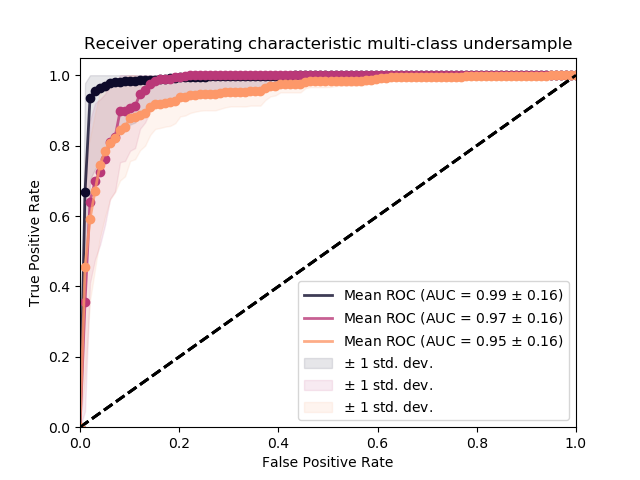

[[1163    0    4]
 [  25    0   40]
 [  32    0   91]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[1006    2    0]
 [   1   20   18]
 [ 118    1  460]]
[[1077    0    4]
 [   0   44    1]
 [  15   85   72]]


<IPython.core.display.Javascript object>


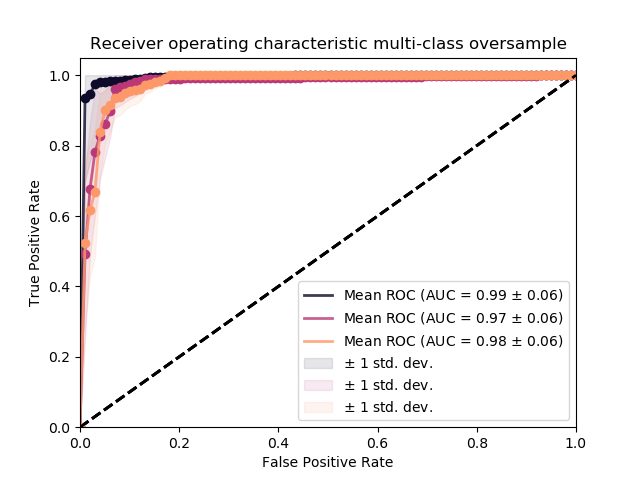

[[1162    0    5]
 [  22    0   43]
 [  23    0  100]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[999   2   7]
 [  0   9  30]
 [ 77   0 502]]
[[1068    0   13]
 [   0   40    5]
 [  10   85   77]]


<IPython.core.display.Javascript object>


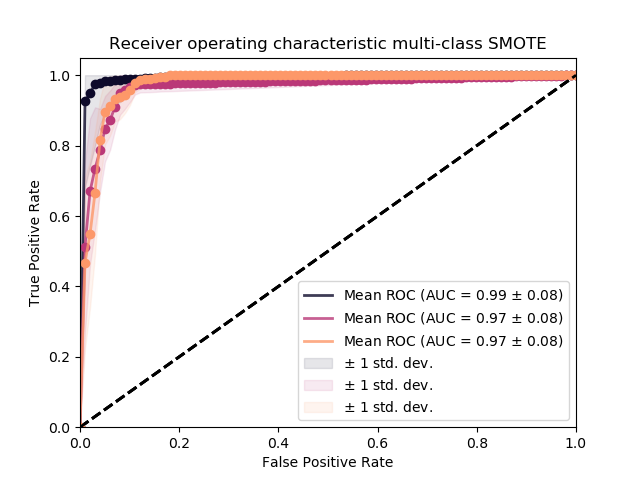

[[1163    0    4]
 [  24    0   41]
 [  34    0   89]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[1005    3    0]
 [   0   13   26]
 [ 140    3  436]]
[[1075    2    4]
 [   0   45    0]
 [  13  116   43]]


<IPython.core.display.Javascript object>

[[1153    0   14]
 [  15   20   30]
 [  29    0   94]]
[[972  12  24]
 [  0  24  15]
 [  3   5 571]]
[[1036   11   34]
 [   0   45    0]
 [  10  127   35]]


<IPython.core.display.Javascript object>


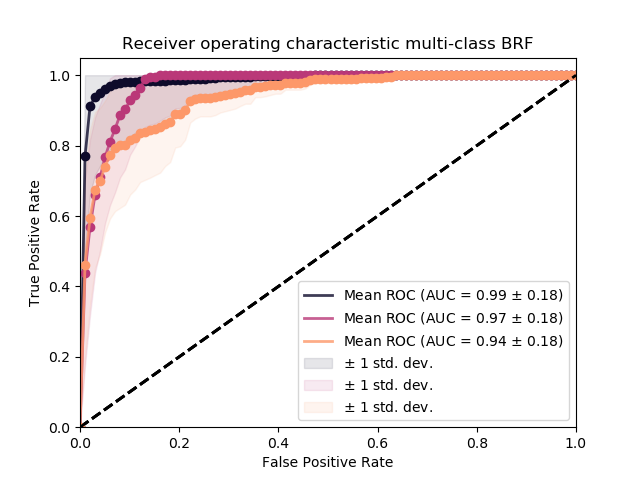

[[688   0  23]
 [  5   0  28]
 [  5  10 151]]
[[649   7   6]
 [  0  15   6]
 [ 18  13 141]]
[[708   5   9]
 [  0  22   0]
 [  0  31  69]]


<IPython.core.display.Javascript object>


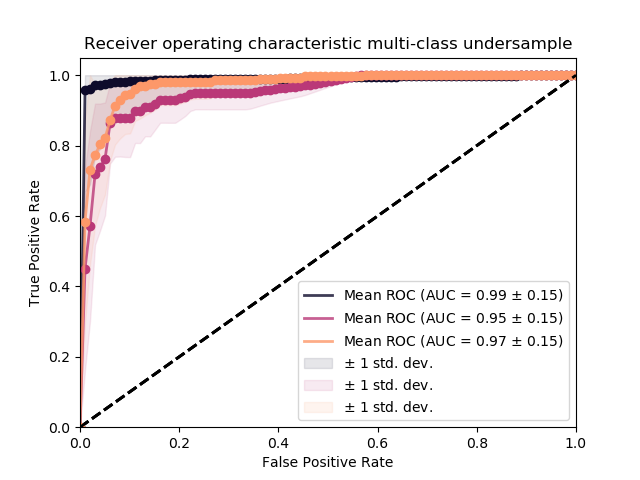

[[708   0   3]
 [  9   0  24]
 [ 35   3 128]]
[[660   0   2]
 [  0   5  16]
 [ 24   8 140]]
[[719   0   3]
 [  0  18   4]
 [  8  12  80]]


<IPython.core.display.Javascript object>


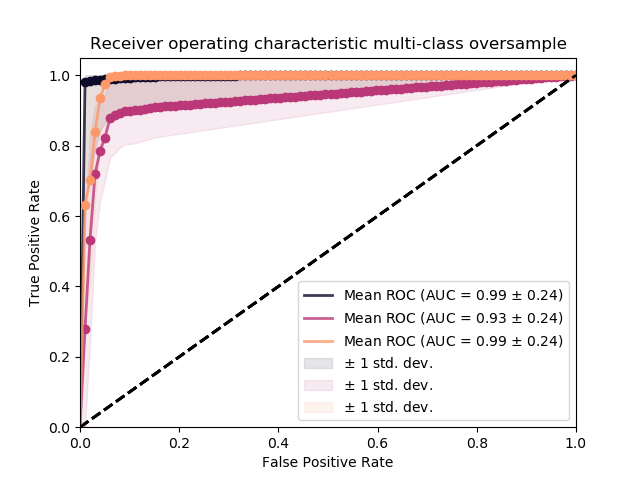

[[703   0   8]
 [  7   0  26]
 [ 28   7 131]]
[[660   0   2]
 [  0   5  16]
 [ 20   3 149]]
[[717   1   4]
 [  0  17   5]
 [  3  11  86]]


<IPython.core.display.Javascript object>

[[709   0   2]
 [ 10   0  23]
 [ 21   1 144]]
[[661   0   1]
 [  2   1  18]
 [ 21   4 147]]
[[721   1   0]
 [  0  21   1]
 [  8  40  52]]


<IPython.core.display.Javascript object>


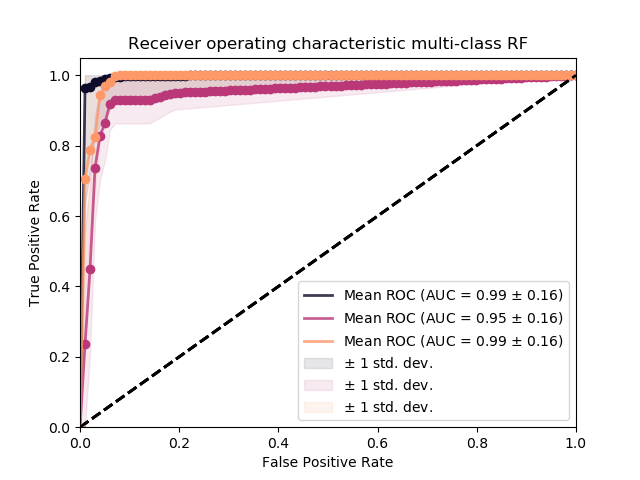

[[688   3  20]
 [  7   0  26]
 [  3  10 153]]
[[647   8   7]
 [  0  12   9]
 [ 10  19 143]]
[[713   4   5]
 [  0  22   0]
 [  0  29  71]]


<IPython.core.display.Javascript object>


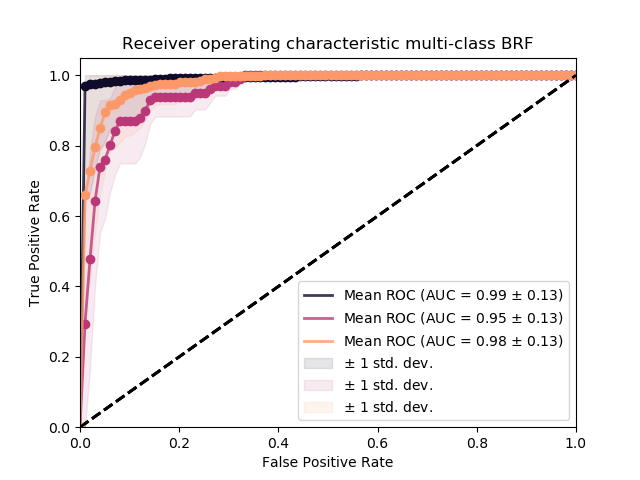

[[552   2   8]
 [  4   0  16]
 [  5   0  33]]
[[543   3   7]
 [  0   5   7]
 [ 41  16 117]]
[[439   1  80]
 [  0  14   0]
 [  0  40  11]]


<IPython.core.display.Javascript object>


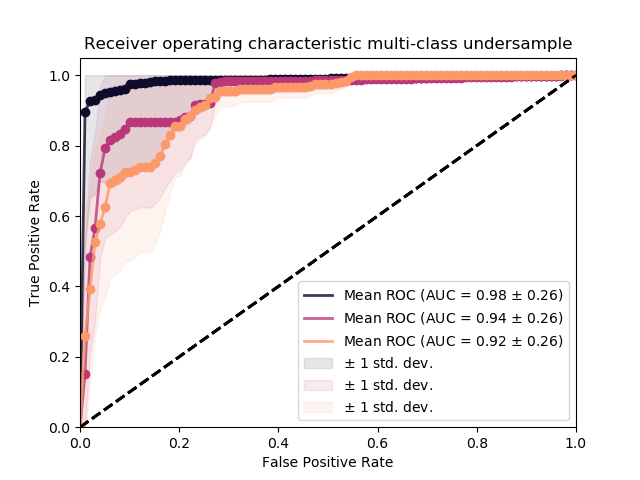

[[560   0   2]
 [  8   0  12]
 [ 13   0  25]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[550   1   2]
 [  0   2  10]
 [ 66   4 104]]
[[519   1   0]
 [  2  12   0]
 [  1  32  18]]


<IPython.core.display.Javascript object>


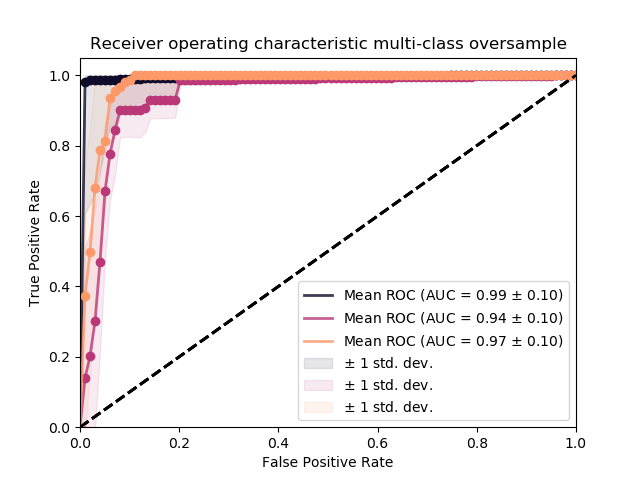

[[558   0   4]
 [  4   0  16]
 [  5   0  33]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[548   2   3]
 [  0   0  12]
 [ 42   0 132]]
[[518   1   1]
 [  1  12   1]
 [  1  32  18]]


<IPython.core.display.Javascript object>


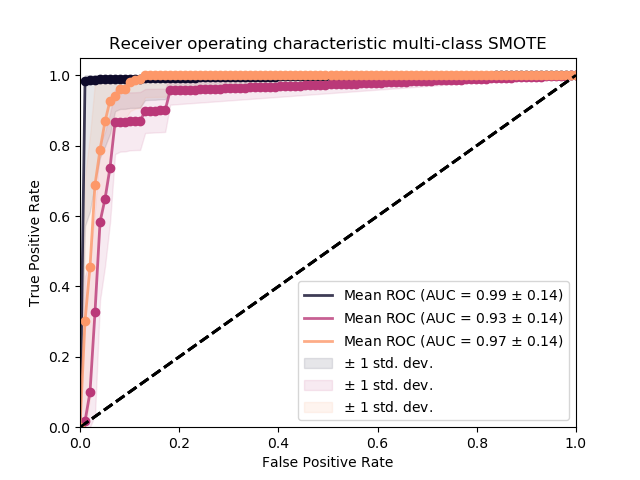

[[559   0   3]
 [ 12   0   8]
 [  8   0  30]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[550   1   2]
 [  0   2  10]
 [ 35   6 133]]
[[518   1   1]
 [  1  13   0]
 [  2  35  14]]


<IPython.core.display.Javascript object>


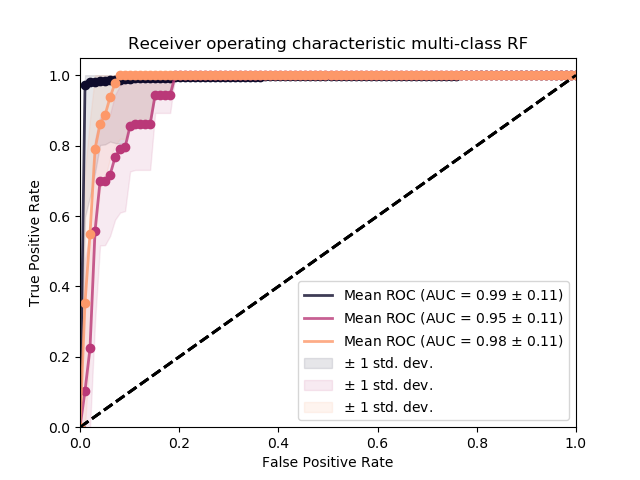

[[551   2   9]
 [  4   0  16]
 [  8   0  30]]
[[541   3   9]
 [  0   5   7]
 [ 37  18 119]]
[[506   4  10]
 [  0  14   0]
 [  0  42   9]]


<IPython.core.display.Javascript object>


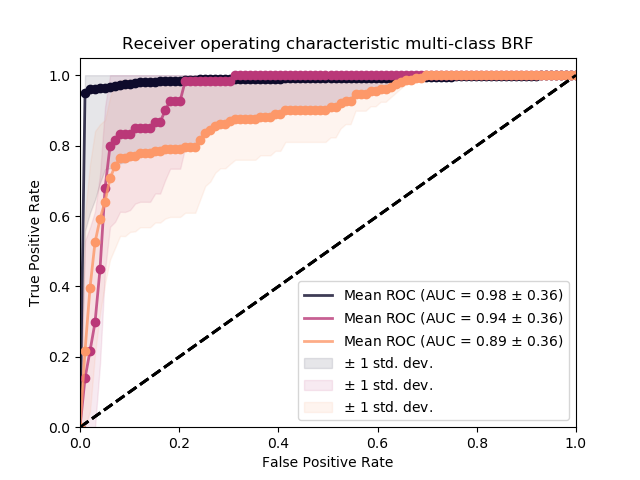

[[475   2   9]
 [  1   0  14]
 [ 19   0  37]]
[[447   3  13]
 [  0   7   2]
 [  0  27  44]]
[[459   3  12]
 [  0   3   6]
 [  4   7  63]]


<IPython.core.display.Javascript object>


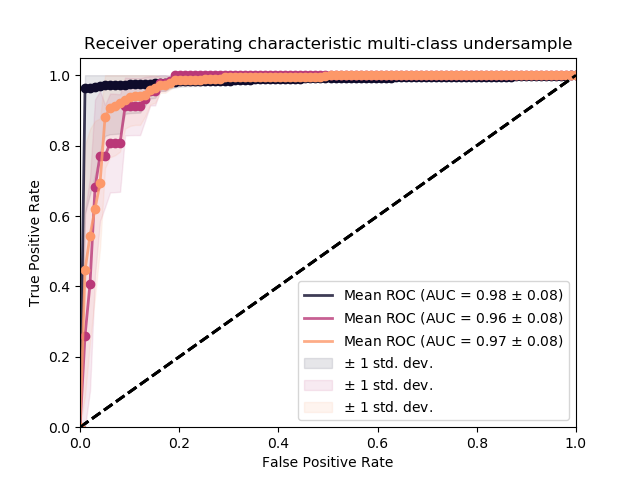

[[482   0   4]
 [ 10   0   5]
 [  8   0  48]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[462   1   0]
 [  3   6   0]
 [ 35   9  27]]
[[472   0   2]
 [  0   0   9]
 [ 16   1  57]]


<IPython.core.display.Javascript object>

[[482   0   4]
 [  1   0  14]
 [  8   0  48]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[460   1   2]
 [  2   7   0]
 [ 30  11  30]]
[[470   0   4]
 [  0   0   9]
 [ 12   1  61]]


<IPython.core.display.Javascript object>


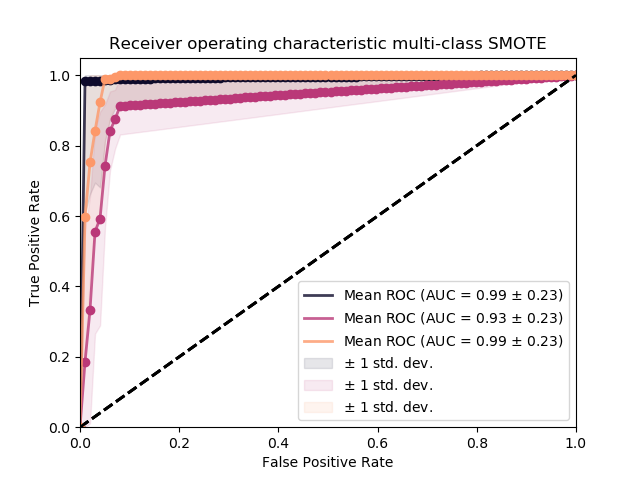

[[482   0   4]
 [ 13   0   2]
 [ 13   0  43]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[460   1   2]
 [  5   4   0]
 [ 23  15  33]]
[[469   0   5]
 [  0   0   9]
 [ 15   1  58]]


<IPython.core.display.Javascript object>


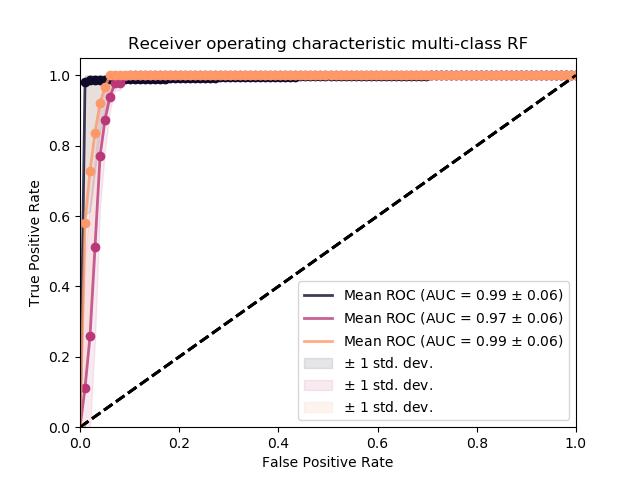

[[477   1   8]
 [  0   0  15]
 [  8   0  48]]
[[450   6   7]
 [  0   7   2]
 [  0  27  44]]
[[466   1   7]
 [  0   5   4]
 [ 11   7  56]]


<IPython.core.display.Javascript object>


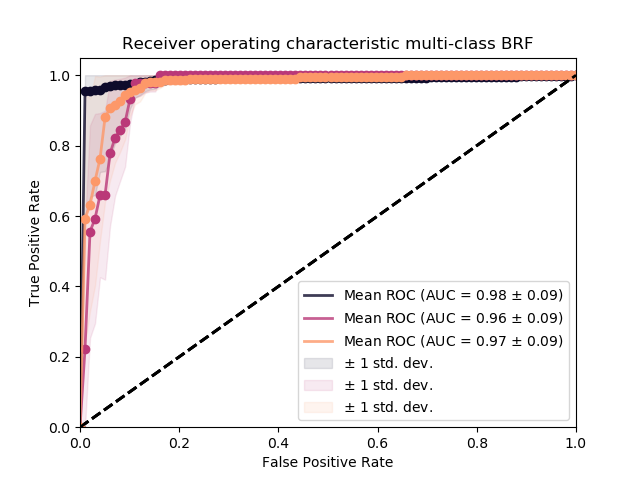

[[407   3  32]
 [  0   0  13]
 [ 15   0  32]]
[[424   5  24]
 [  0   3   3]
 [  0   9  49]]
[[445   2   5]
 [  0   0   7]
 [ 10   7  44]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


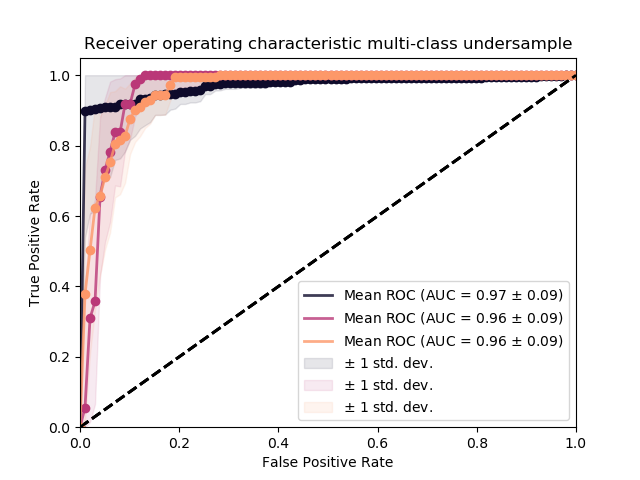

[[438   0   4]
 [  5   0   8]
 [ 13   0  34]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[446   1   6]
 [  2   3   1]
 [ 29   3  26]]
[[451   0   1]
 [  0   0   7]
 [ 13   0  48]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

[[438   0   4]
 [  2   0  11]
 [  9   0  38]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[444   2   7]
 [  3   3   0]
 [  7   8  43]]
[[449   0   3]
 [  0   0   7]
 [ 13   4  44]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

[[439   0   3]
 [ 13   0   0]
 [ 13   0  34]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[446   2   5]
 [  3   3   0]
 [  2  16  40]]
[[449   0   3]
 [  0   0   7]
 [ 11   0  50]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

[[433   0   9]
 [  0   0  13]
 [  9   0  38]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[422   8  23]
 [  0   5   1]
 [  0  18  40]]
[[440   3   9]
 [  0   4   3]
 [ 10   6  45]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

[[368   6  27]
 [  0   0   9]
 [ 17   0  55]]
[[395  11  13]
 [  0   6   0]
 [  0  13  12]]
[[407   2  15]
 [  0   2   6]
 [  0   1  35]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

[[396   0   5]
 [  5   0   4]
 [ 39   0  33]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[416   2   1]
 [  1   5   0]
 [ 11   6   8]]
[[423   0   1]
 [  0   0   8]
 [ 24   0  12]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

[[392   0   9]
 [  4   0   5]
 [ 32   0  40]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[416   0   3]
 [  2   4   0]
 [  8   8   9]]
[[423   0   1]
 [  0   0   8]
 [ 13   0  23]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


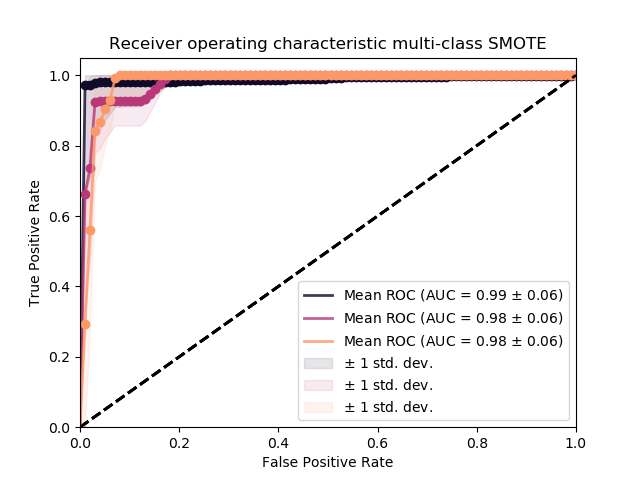

[[394   0   7]
 [  8   0   1]
 [ 20   0  52]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[416   0   3]
 [  3   3   0]
 [  6  10   9]]
[[423   0   1]
 [  0   0   8]
 [ 11   0  25]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


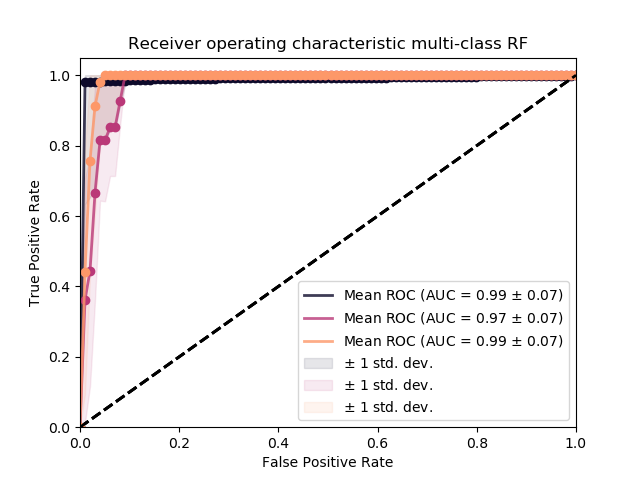

[[372   3  26]
 [  0   0   9]
 [ 16   0  56]]
[[399  10  10]
 [  0   6   0]
 [  0  18   7]]
[[404   1  19]
 [  0   7   1]
 [  0   0  36]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


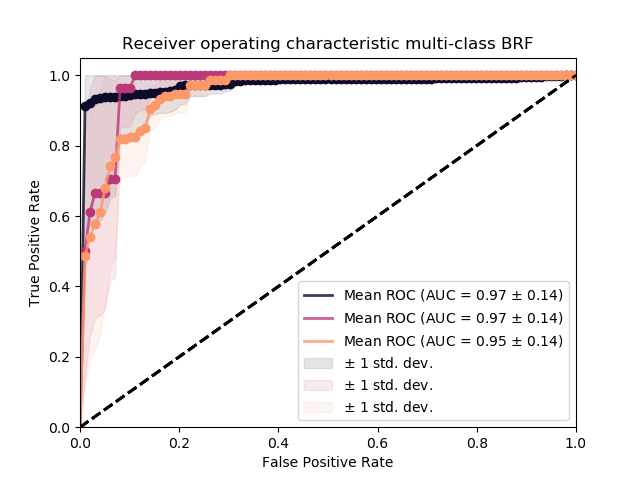

In [14]:
data3 = []
sd_data3 = []

for n in ['10s', '20s', '30s', '40s', '50s', '60s']:
#for n in ['60s']:
    x = 'yfilt'
    y = n
    z = 'hSNR'
    cat = BondoDataSet(f'../split_feature_files/train_feature_files/train_{x}_{y}_{z}.csv')


    cat = combine_classes(cat)

    catalog = f'train_{x}_{y}_{z}'
    nb_classes = 3
    us, us_std, tprs, threshs = get_metrics_CV(cat, 3, nb_classes, 'undersample', catalog)
    os, os_std, tprs, threshs = get_metrics_CV(cat, 3, nb_classes, 'oversample', catalog)
    sm, sm_std, tprs, threshs = get_metrics_CV(cat, 3, nb_classes, 'SMOTE', catalog)
    rf, rf_std, tprs, threshs = get_metrics_CV(cat, 3, nb_classes, 'RF', catalog)
    brf, brf_std, tprs, threshs = get_metrics_CV(cat, 3, nb_classes, 'BRF', catalog)

    pupu = {'US': us, 'OS': os, 'SMOTE': sm, 'RF': rf, 'BRF': brf}
    pupu_std = {'US': us_std, 'OS': os_std, 'SMOTE': sm_std, 'RF': rf_std, 'BRF': brf_std}


    data3.append(pupu)
    sd_data3.append(pupu_std)


In [17]:
df3 = pd.DataFrame(data3)
df3.index = [10,20,30,40,50,60]
sd_df3 = pd.DataFrame(sd_data3) 
sd_df3.index = [10,20,30,40,50,60]

/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


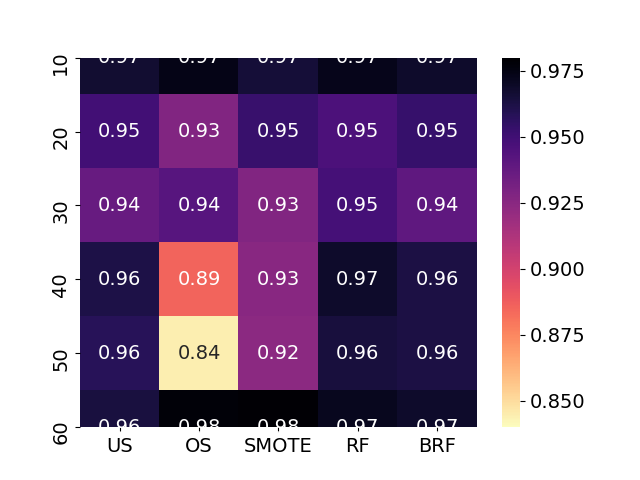

In [19]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

plt.figure()
ax = sns.heatmap(df3, annot=True, cmap='magma_r', vmin=0.84, vmax=0.98, fmt=".2",  annot_kws={"size": 14})


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


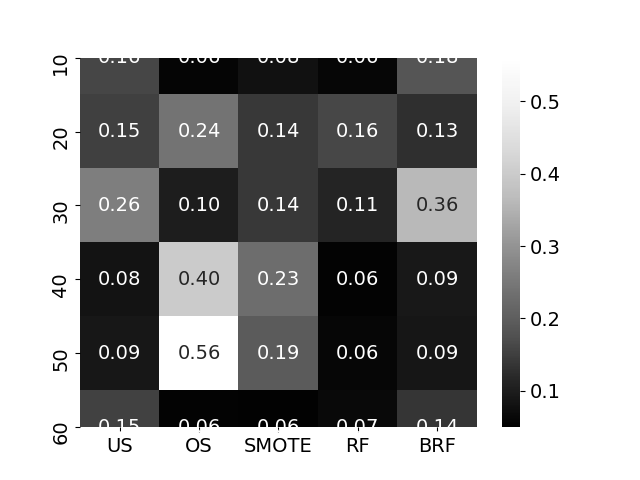

In [20]:
plt.figure()
sns.heatmap(sd_df3, annot=True, cmap='Greys_r', vmin=0.56, vmax=0.05,  fmt="3.2f",  annot_kws={"size": 14})

## Model selection

In [ ]:
x = 'yfilt'
y = '40s'
z = 'hSNR'
cat = BondoDataSet(f'../split_feature_files/train_feature_files/train_{x}_{y}_{z}.csv')

X_train = np.asarray(cat.df[cat.feature_names])
y_train = cat.target

 # applying SMOTE to our data and checking the class counts
#X_train, y_train = SMOTE(k_neighbors=4).fit_resample(X_train, y_train)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

## Final model

[[482   0   4]
 [ 13   0   2]
 [ 13   0  43]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[460   1   2]
 [  5   4   0]
 [ 23  15  33]]
[[469   0   5]
 [  0   0   9]
 [ 15   1  58]]


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


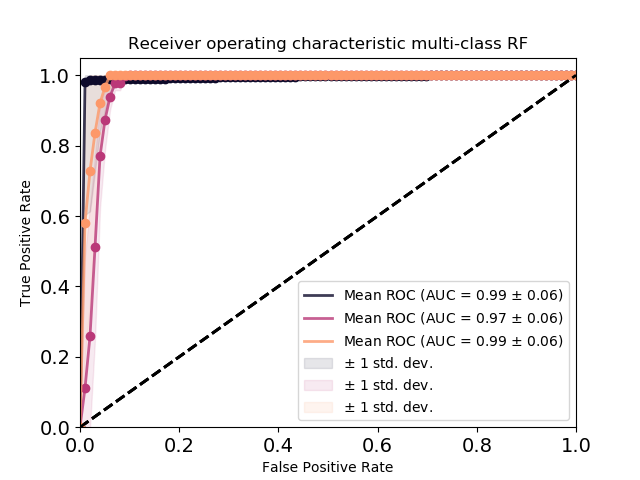

In [21]:
x = 'yfilt'
y = '40s'
z = 'hSNR'
combine = 'yes'
cat = BondoDataSet(f'../split_feature_files/train_feature_files/train_{x}_{y}_{z}.csv')

def combine_classes(cat):
    cat.df.loc[cat.df['event_class'] == 2, 'event_class'] = 0
    cat.df.loc[cat.df['event_class'] == 5, 'event_class'] = 0
    cat.df.loc[cat.df['event_class'] == 3, 'event_class'] = 2
    cat.df.loc[cat.df['event_class'] == 4, 'event_class'] = 0
    return cat
cat = combine_classes(cat)

catalog = 'final_hSNR_40s_3classes'
nb_classes = 3
bla1, bla2, tprs, threshs = get_metrics_CV(cat, 3, nb_classes, 'RF', catalog)

In [22]:
m_thresh = []
#for r in [1,5,9]:
for r in [1,4,7]:
    m_thresh.append(threshs[r][np.where(tprs[r] > 0.9)[0][0]])
print(np.mean(m_thresh))

0.237142857143


In [23]:
x = 'yfilt'
y = '40s'
z = 'hSNR'

# Train classifier
cat_train = BondoDataSet(f'../split_feature_files/train_feature_files/train_{x}_{y}_{z}.csv')

cat_train = combine_classes(cat_train)

#cat_train.df.loc[cat_train.df['event_class'] == 2, 'event_class'] = 1
#cat_train.df.loc[cat_train.df['event_class'] == 3, 'event_class'] = 2
X_train = np.asarray(cat_train.df[cat_train.feature_names])
y_train = cat_train.df['event_class']

#ros = RandomOverSampler(random_state=42)
#rus = RandomUnderSampler(random_state=42)
#X_train, y_train = ros.fit_resample(X_train, y_train)
#X_train, y_train = SMOTE(k_neighbors=4).fit_resample(X_train, y_train)

# Test data
cat_test = BondoDataSet(f'../split_feature_files/test_feature_files_rand/test_{x}_{y}_{z}.csv')
cat_test = combine_classes(cat_test)

#cat_test.df.loc[cat_test.df['event_class'] == 2, 'event_class'] = 1
#cat_test.df.loc[cat_test.df['event_class'] == 3, 'event_class'] = 2
X_test = np.asarray(cat_test.df[cat_test.feature_names])
y_test = cat_test.df['event_class']

clf = RandomForestClassifier(n_estimators=2000,criterion='gini',max_features='auto', \
                         n_jobs=-1, min_samples_leaf = 4, max_depth=60, min_samples_split=2, \
                         oob_score=False, bootstrap=False, random_state=10)


# Train the Classifier 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
probas = clf.predict_proba(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3, output_dict=True))

[[582   0   4]
 [  4   0  21]
 [ 18   0 154]]
{'0.0': {'precision': 0.9635761589403974, 'recall': 0.9931740614334471, 'f1-score': 0.9781512605042016, 'support': 586}, '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 25}, '2.0': {'precision': 0.8603351955307262, 'recall': 0.8953488372093024, 'f1-score': 0.8774928774928775, 'support': 172}, 'accuracy': 0.9399744572158365, 'macro avg': {'precision': 0.6079704514903745, 'recall': 0.6295076328809165, 'f1-score': 0.6185480459990264, 'support': 783}, 'weighted avg': {'precision': 0.9101319064755526, 'recall': 0.9399744572158365, 'f1-score': 0.9248089573234191, 'support': 783}}


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
for i in range(len(y_pred)):
    if probas[i][1] > 0.23:
        y_pred[i] = 1

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    ax.tick_params(labelsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    
    plt.tight_layout()


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


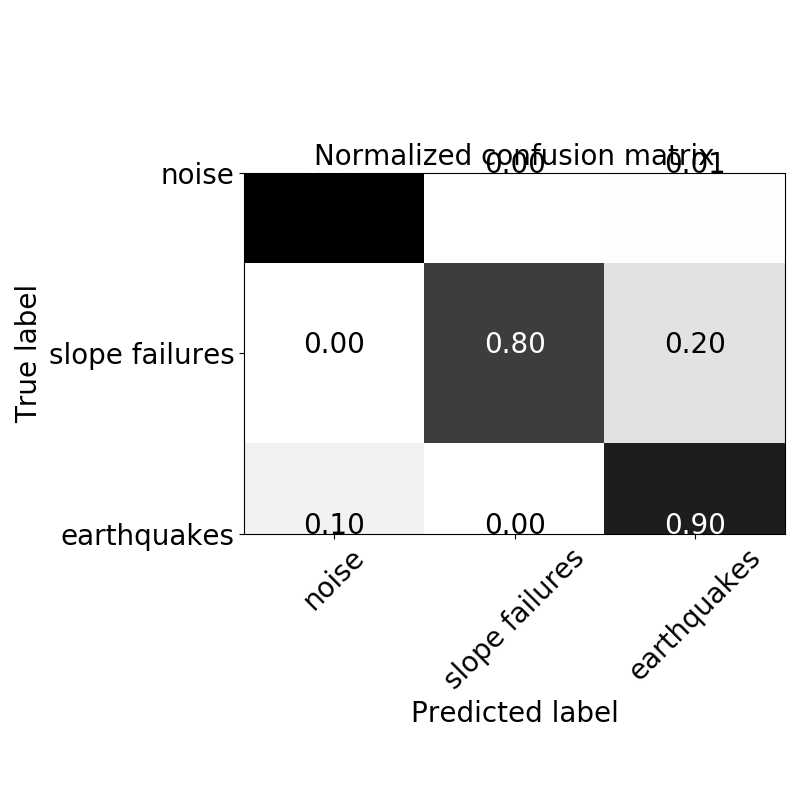

In [26]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), ['noise', 'slope failures','earthquakes'], normalize=True, title='Normalized confusion matrix', cmap=plt.cm.Greys)

/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


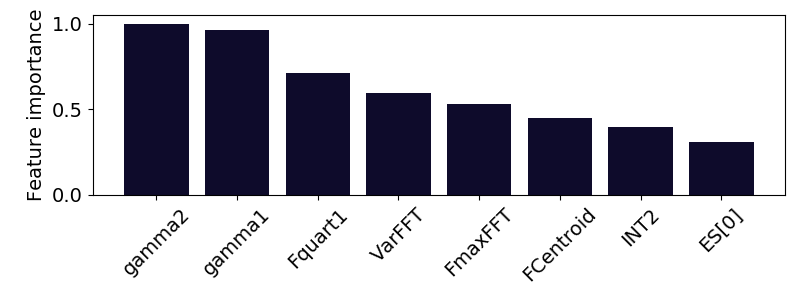

In [27]:
# Plot feature importance
cmcolors = plt.get_cmap('magma').colors
#colors = cycle([cmcolors[20],cmcolors[100],cmcolors[150],cmcolors[200]])
colors = cycle([cmcolors[20],cmcolors[130],cmcolors[200]])
cat_all = BondoDataSet(f'../all_feature_files/train_feature_files/all_features_train_{x}_{y}_{z}.csv')
xx = sorted(zip(cat_all.df[cat_all.feature_names], clf.feature_importances_), key=lambda x: x[1], reverse=True)[:8]
xs = np.arange(1, len(xx) + 1)
fig, ax = plt.subplots(figsize=(8,3))
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.bar(xs, [i[1] / xx[0][1] for i in xx], color=cmcolors[20])
ax.set_xticks(xs)
ax.set_xticklabels([i[0] for i in xx], rotation=45)

plt.ylabel('Feature importance', fontsize=14)
plt.tight_layout()
plt.show()



['gamma2', 'gamma1', 'Fquart1', 'VarFFT', 'event_class']


/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/seaborn/axisgrid.py:1270: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  squeeze=False)


<IPython.core.display.Javascript object>


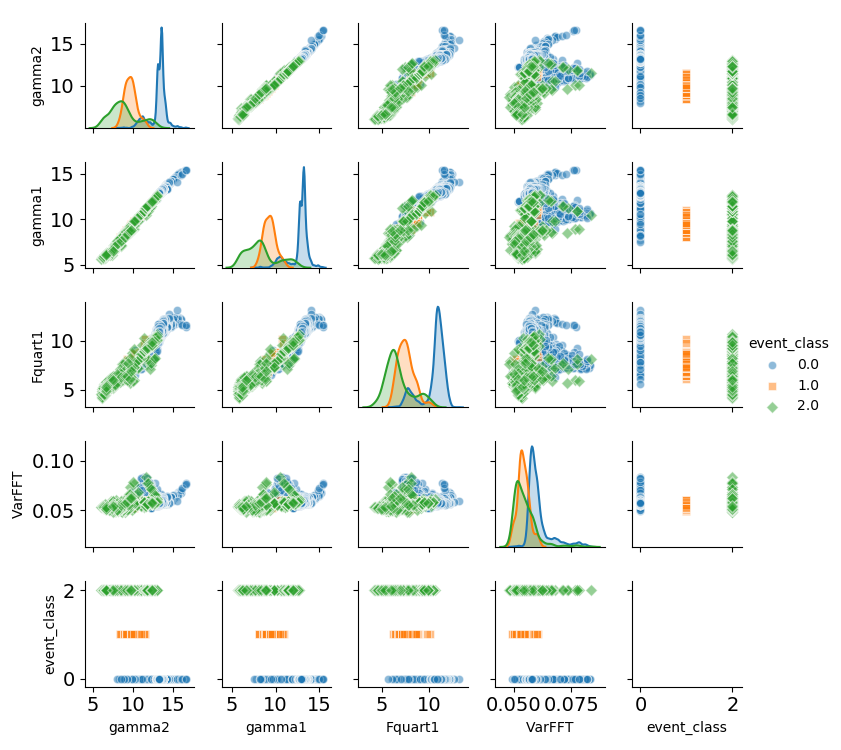

/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/michiwen/anaconda3/envs/imblearn/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [28]:
def make_pairplot(df, feat_list,name):
    #matplotlib.rc('xtick', labelsize=14) 
    #matplotlib.rc('ytick', labelsize=14) 
    # Choose features to plot
    flist = [i[0] for i in xx[:4]] + ['event_class']
    #flist = ['s1', 'v1', 's2', 'v2', 's3', 'v3', 'class']
    print(flist)
    features = df[flist] 
    # Make the pair plot of features with kernel density estiamtion on diagonal
    ax = sns.pairplot(features, hue = 'event_class', diag_kind = 'kde', plot_kws=dict(alpha = 0.5),
                   diag_kws=dict(shade=True), height=(1.5), markers=["o", "s", "D"]);
    plt.show()
def combine_classes_pairplot(cat):
    cat.loc[cat['event_class'] == 2, 'event_class'] = 0
    cat.loc[cat['event_class'] == 5, 'event_class'] = 0
    cat.loc[cat['event_class'] == 3, 'event_class'] = 2
    cat.loc[cat['event_class'] == 4, 'event_class'] = 0
    cat = cat[cat['event_class'] != 9]
    return cat
    

cat_all.df = combine_classes_pairplot(cat_all.df)

make_pairplot(cat_all.df, 1, f'{x}_{y}_{z}')

In [29]:
header = ['duration', 'RappMaxMean', 'RappMaxMedian', 'AsDec',
       'KurtoSig', 'KurtoEnv', 'SkewnessSig', 'SkewnessEnv', 'CorPeakNumber',
       'INT1', 'INT2', 'INT_RATIO', 'ES[0]', 'ES[1]', 'ES[2]', 'ES[3]',
       'ES[4]', 'KurtoF[0]', 'KurtoF[1]', 'KurtoF[2]', 'KurtoF[3]',
       'KurtoF[4]', 'DistDecAmpEnv', 'env_max/duration(Data,sps)', 'MeanFFT',
       'MaxFFT', 'FmaxFFT', 'FCentroid', 'Fquart1', 'Fquart3', 'MedianFFT',
       'VarFFT', 'NpeakFFT', 'MeanPeaksFFT', 'E1FFT', 'E2FFT', 'E3FFT',
       'E4FFT', 'gamma1', 'gamma2', 'gammas', 'SpecKurtoMaxEnv',
       'SpecKurtoMedianEnv', 'RATIOENVSPECMAXMEAN', 'RATIOENVSPECMAXMEDIAN',
       'DISTMAXMEAN', 'DISTMAXMEDIAN', 'NBRPEAKMAX', 'NBRPEAKMEAN',
       'NBRPEAKMEDIAN', 'RATIONBRPEAKMAXMEAN', 'RATIONBRPEAKMAXMED',
       'NBRPEAKFREQCENTER', 'NBRPEAKFREQMAX', 'RATIONBRFREQPEAKS', 'DISTQ2Q1',
       'DISTQ3Q2', 'DISTQ3Q1']

In [30]:
import glob 
# For mode == event
test_2019 = {}
#for i in range(197,198):
for i in range(94,270):
    #for f in glob.glob(f"../feature_files_2019/LERA1/{i}_*.csv"):
    for f in glob.glob(f"../feature_files_2019/40_seconds/{i}_*.csv"):
        test = pd.read_csv(f, header=None)
        for n in range(3):
            test1 = test[test.columns[int(n*58):int((n+1)*58)]]
            test1.columns = header
            probas = clf.predict_proba(test1[cat_train.feature_names])
            test_2019[f'{i}_{n}'] = probas
    

In [31]:
def most_frequent(List): 
    return max(set(List), key = List.count)  

# Weighted vote
classes_weighted_2019 = {}
for i in range(94,270):
#for i in range(197,198):
    final_class = []
    for l in range(len(test_2019[f'{i}_2'])):
        weighted_vote = []
        for s in range(3):
            #weighted_vote.extend(int(np.max(test_2019[f'{i}_{s}'][l])*10) * [np.argmax(test_2019[f'{i}_{s}'][l])])
            if test_2019[f'{i}_{s}'][l][1] > 0.23:
                weighted_vote.extend([1])
            else:
                weighted_vote.extend([np.argmax(test_2019[f'{i}_{s}'][l])])
        final_class.append(most_frequent(weighted_vote))
    classes_weighted_2019[f'{i}'] = final_class

In [32]:
# Get Dictionarry with file starttimes
import os
#t = obspy.UTCDateTime(2019, 1, 1)
file_stt = {}
for i in os.listdir("../feature_files_2019/40_seconds/"):
    day = i.split('_')[0]
    hour = i.split('_')[1].split('-')[0]
    minute = i.split('_')[1].split('-')[1]
    seconds = i.split('_')[1].split('-')[2].split('.')[0]
    microseconds = i.split('_')[1].split('-')[2].split('.')[1]
    file_stt[day] = obspy.UTCDateTime(year=2019, julday=int(day), hour=int(hour), minute=int(minute), second=int(seconds), microsecond=int(microseconds))

In [34]:
eqdays = []
rfdays = []
dcdays = []
for i in range(94,270):
    classifi = np.asarray(classes_weighted_2019[f'{i}'])
    if len(np.where(classifi == 2)[0]) > 40:
        # > 500 because data gaps classified as earhtquake which can be > 300
        eqdays.append(i)
    if len(np.where(classifi == 1)[0]) > 2:
        rfdays.append(i)
    #if len(np.where(classifi == 4)[0]) > 10:
    #    dcdays.append(i)

In [35]:
print(len(rfdays))
print(rfdays)

9
[94, 114, 116, 142, 197, 210, 220, 225, 241]
